*Data 620 Assignment Week 10: Document Classification*
    - Vikas Sinha
    - 11/10/2019

Objective: Use of Machine Learning document classifiers to classify emails into Spam and Non-spam (ham) categories

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

*** In this project we use the UCI Spambase dataset to classify spam and non-spam emails. ***

The database is available from the following URL:
http://archive.ics.uci.edu/ml/datasets/Spambase

In [5]:
# Read the spam data
d1 = pd.read_csv("data/spambase.data", header=None)

Examine the dimensions of the dataset, which includes both categories (spam and non-spam).

In [6]:
d1.shape

(4601, 58)

** Attribute Information: **

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes:

48 continuous real [0,100] attributes of type word_freq_WORD
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR]
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average
= average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest
= length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total
= sum of length of uninterrupted sequences of capital letters
= total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. 

I renamed the columns below, based on the file *spambase.DOCUMENTATION*, to allow easier interpretability. Names of input features related to word frequencies are prefixed with "wf\_", features related frequencies of specific characters are prefixed with "cf\_". 

In [7]:
# Rename the columns.
# wf -> word frequency
# cf -> char frequency
features = [
    "wf_make",    
    "wf_address",    
    "wf_all",    
    "wf_3d",    
    "wf_our",    
    "wf_over",    
    "wf_remove",    
    "wf_internet",    
    "wf_order",    
    "wf_mail",    
    "wf_receive",    
    "wf_will",    
    "wf_people",    
    "wf_report",    
    "wf_addresses",    
    "wf_free",    
    "wf_business",    
    "wf_email",    
    "wf_you",    
    "wf_credit",    
    "wf_your",    
    "wf_font",    
    "wf_000",    
    "wf_money",    
    "wf_hp",    
    "wf_hpl",    
    "wf_george",    
    "wf_650",    
    "wf_lab",    
    "wf_labs",    
    "wf_telnet",    
    "wf_857",    
    "wf_data",    
    "wf_415",    
    "wf_85",    
    "wf_technology",   
    "wf_1999",    
    "wf_parts",    
    "wf_pm",    
    "wf_direct",    
    "wf_cs",    
    "wf_meeting",    
    "wf_original",    
    "wf_project",    
    "wf_re",    
    "wf_edu",    
    "wf_table",    
    "wf_conference",   
    "cf_semic",    
    "cf_lpara",    
    "cf_lbraket",
    "cf_excla",
    "cf_dollar",
    "cf_hash",
    "cap_rl_ave",
    "cap_rl_longest",
    "cap_rl_total"
]

In [10]:
# Add the column for the response variable ("spam").
# The last column (*"spam"*) of *'spambase.data'* denotes whether
# the e-mail was considered spam (1) or not (0).
Columns = features.copy()
Columns.append("spam")
d1.columns = Columns
d1.head()

,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,...,cf_semic,cf_lpara,cf_lbraket,cf_excla,cf_dollar,cf_hash,cap_rl_ave,cap_rl_longest,cap_rl_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


** Data Exploration **

In [13]:
dh = d1[d1["spam"] == 0]
ds = d1[d1["spam"] == 1]

print("Number of rows of Ham = {}" .format(dh.shape[0]))
print("Number of rows of Spam = {}" .format(ds.shape[0]))

Number of rows of Ham = 2788
Number of rows of Spam = 1813


We can use density plots to examine the distribution of a few variables across the two categories.

We select two variables for this purpose and examine their distribution for Spam and Non-spam data:
- The first variable represents the frequency of the "$" sign in the email.
- The second variable represents the frequency of the word "money" in the email.

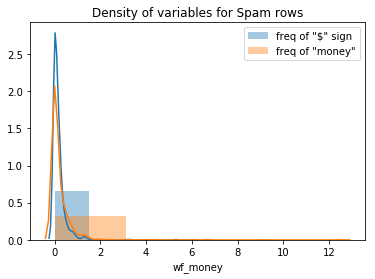

In [20]:
import seaborn as sns
sns.distplot(ds["cf_dollar"], hist=True, label="freq of \"$\" sign", bins=4);
sns.distplot(ds["wf_money"], hist=True, label="freq of \"money\"", bins=4);
plt.title("Density of variables for Spam rows")
plt.legend();

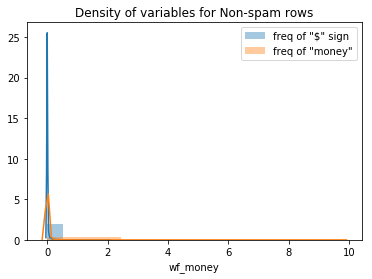

In [21]:

sns.distplot(dh["cf_dollar"], hist=True, label="freq of \"$\" sign", bins=4);
sns.distplot(dh["wf_money"], hist=True, label="freq of \"money\"", bins=4);
plt.title("Density of variables for Non-spam rows")
plt.legend();

We see from the above plots that the two variables selected have _different densities_ across the Spam and Non-spam subsets:
- The variable *cf_dollar* is the frequency of occurrence of the "$" sign
- The variable *wf_money* is the frequency of occurrence of the word "money"


Both of these variables are more frequently present in the Spam subset, as shown in the above plots.

**Building, Evaluating and Comparing Classification Models**

We now build models to predict the Response variable "spam" based on the other variables.
The first model is a Gradient Boosting model.

**Gradient Boosting**

In [25]:
X = d1[features]
y = d1["spam"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#y_test.shape
#X_test.shape

# fit model on training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
# make predictions
predictions = xgb.predict(X_test)
predictions[0:9]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

Accuracy: 95.19%


In [27]:
# confusion matrix for Gradient Boosting
confusion_matrix(y_test, predictions)

array([[856,  30],
       [ 43, 590]])

** Random Forest **

The second classification model we attempt is a Random Forest model.

In [28]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf_model = RandomForestClassifier(n_estimators=100)

#Train the model using the training set
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy of Random Forest classifier.

In [30]:
# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred)*100.0)

Accuracy: 96.18169848584596


In [31]:
# confusion matrix for Random Forest
confusion_matrix(y_test, y_pred)

array([[870,  16],
       [ 42, 591]])

*** Importance of Features using Random Forest Classifier ***

We can also use the Random Forest classifier to obtain the top 10 most important features.

In [32]:
feature_imp = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
# Show the top ten features by importance
feature_imp[0:9]

cf_excla          0.118987
cf_dollar         0.097229
wf_remove         0.086801
wf_free           0.070583
cap_rl_ave        0.066005
wf_your           0.058858
cap_rl_longest    0.058084
cap_rl_total      0.037440
wf_hp             0.036306
dtype: float64

** Summary and Conclusions **

Using data from the UCI Spam Database, we implemented Gradient Boosting and Random Forest classifiers
to classify emails into Spam and Non-Spam categories. The features used were based on typical characteristics thought to be present in Spam email, such as the occurrence of specific words and letters (for example, the word "money", or excessive use of capitalized letters).

We also showed the confusion matrix resulting from the predictions made by each classifier, and obtained a feature importance ranking using the Random Forest model.

We found that both classifiers achieved similar overall accuracies (95% for Gradient Boosting vs 96% for Random Forest).